# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Functions

In [1]:
import math
import numpy as np

def parse_vrp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and filter empty lines
    lines = [line.strip() for line in lines if line.strip()]

    # Parse metadata
    metadata = {}
    i = 0
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:
            key, value = lines[i].split(':', 1)
            metadata[key.strip()] = value.strip().strip('"')
        i += 1

    # Parse node coordinates (1-based in file, but we'll make 0-based list)
    coords = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()
        if len(parts) == 3:
            node_id = int(parts[0]) - 1  # Make 0-based
            x, y = int(parts[1]), int(parts[2])
            # Insert at correct index in case not sequential (though they usually are)
            while len(coords) <= node_id:
                coords.append(None)
            coords[node_id] = (x, y)
        i += 1

    # Parse demands (0-based list)
    demands = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()
        if len(parts) == 2:
            node_id = int(parts[0]) - 1  # Make 0-based
            demand = int(parts[1])
            while len(demands) <= node_id:
                demands.append(None)
            demands[node_id] = demand
        i += 1

    # Parse depot(s) — usually just one, 1-based
    depots = []
    i += 1  # Skip section header
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])
        if depot == -1:
            break
        depots.append(depot - 1)  # Make 0-based
        i += 1

    # Compute distance matrix (Euclidean 2D)
    dimension = int(metadata.get('DIMENSION', len(coords)))
    dist_matrix = np.zeros((dimension, dimension))
    for a in range(dimension):
        for b in range(dimension):
            x1, y1 = coords[a]
            x2, y2 = coords[b]
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return {
        'metadata': metadata,
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of integers, 0-based
        'depots': depots,  # List of 0-based indices (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # Numpy array of floats
    }

## NSGA-II Implementation

In [44]:
# --- NSGA-II Implementation (cleaned) ---
import numpy as np
import random
import time

class NSGAII:
    def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
        self.data = data
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []

        # Pre-compute frequently accessed values
        self.dist_matrix = self.data['dist_matrix']
        self.capacity = int(self.data['metadata']['CAPACITY'])
        self.demands = self.data['demands']
        self.n_customers = len(self.data['coords']) - 1
        self.customer_range = list(range(1, self.n_customers + 1))

    def split_routes(self, customer_sequence):
        """Route splitting with capacity constraints"""
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = self.demands[customer]
            if load + demand > self.capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def calculate_route_distance(self, route):
        """Calculate distance for a single route"""
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_individual(self, individual):
        """Assignment-compliant: Total Distance vs Standard Deviation"""
        if individual['objectives'] is not None:
            return
        routes = individual['routes']
        route_distances = [self.calculate_route_distance(route) for route in routes]
        total_dist = sum(route_distances)
        if len(route_distances) > 1:
            mean_length = total_dist / len(route_distances)
            variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)
            route_balance = variance**0.5  # Standard deviation
        else:
            route_balance = 0.0
        individual['objectives'] = [total_dist, route_balance]

    def evaluate_population(self, population):
        for individual in population:
            self.evaluate_individual(individual)

    def generate_initial_population(self):
        population = []
        # Add 2 heuristic solutions for better starting points
        if self.pop_size >= 2:
            nn_seq = self.nearest_neighbor_solution()
            population.append(self.create_individual(nn_seq))
            bal_seq = self.balanced_insertion_solution()
            population.append(self.create_individual(bal_seq))
            for _ in range(self.pop_size - 2):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        else:
            for _ in range(self.pop_size):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        return population

    def nearest_neighbor_solution(self):
        """Distance-optimized solution"""
        unvisited = set(self.customer_range)
        solution = []
        current = 0
        while unvisited:
            distances = [(self.dist_matrix[current, customer], customer)
                        for customer in unvisited]
            _, next_customer = min(distances)
            solution.append(next_customer)
            unvisited.remove(next_customer)
            current = next_customer
        return solution

    def balanced_insertion_solution(self):
        """Balance-focused solution"""
        customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
        customers_by_distance.sort()
        solution = []
        near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
        far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]
        for i in range(max(len(near), len(far))):
            if i < len(near):
                solution.append(near[i])
            if i < len(far):
                solution.append(far[i])
        return solution

    def fast_non_dominated_sort(self, population):
        """Non-dominated sorting"""
        n = len(population)
        objectives = [ind['objectives'] for ind in population]
        domination_count = [0] * n
        dominated_solutions = [[] for _ in range(n)]
        for i in range(n):
            obj1_i, obj2_i = objectives[i]
            for j in range(i + 1, n):
                obj1_j, obj2_j = objectives[j]
                if (obj1_i <= obj1_j and obj2_i <= obj2_j) and (obj1_i < obj1_j or obj2_i < obj2_j):
                    dominated_solutions[i].append(j)
                    domination_count[j] += 1
                elif (obj1_j <= obj1_i and obj2_j <= obj2_i) and (obj1_j < obj1_i or obj2_j < obj2_i):
                    dominated_solutions[j].append(i)
                    domination_count[i] += 1
        current_front = [i for i in range(n) if domination_count[i] == 0]
        rank = 1
        for i in current_front:
            population[i]['rank'] = rank
        while current_front:
            next_front = []
            for i in current_front:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        next_front.append(j)
            if next_front:
                rank += 1
                for i in next_front:
                    population[i]['rank'] = rank
            current_front = next_front

    def calculate_crowding_distance(self, population):
        """Calculate crowding distance"""
        for ind in population:
            ind['crowding_distance'] = 0.0
        rank_groups = {}
        for i, ind in enumerate(population):
            rank = ind['rank']
            if rank not in rank_groups:
                rank_groups[rank] = []
            rank_groups[rank].append(i)
        for indices in rank_groups.values():
            n_front = len(indices)
            if n_front <= 2:
                for i in indices:
                    population[i]['crowding_distance'] = float('inf')
                continue
            for obj_idx in range(2):
                indices.sort(key=lambda i: population[i]['objectives'][obj_idx])
                population[indices[0]]['crowding_distance'] = float('inf')
                population[indices[-1]]['crowding_distance'] = float('inf')
                obj_range = population[indices[-1]]['objectives'][obj_idx] - population[indices[0]]['objectives'][obj_idx]
                if obj_range > 0:
                    for j in range(1, n_front - 1):
                        i = indices[j]
                        if population[i]['crowding_distance'] != float('inf'):
                            prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                            next_obj = population[indices[j+1]]['objectives'][obj_idx]
                            population[i]['crowding_distance'] += (next_obj - prev_obj) / obj_range

    def tournament_selection(self, population, tournament_size=2):
        """Tournament selection"""
        tournament = random.sample(population, tournament_size)
        return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

    def create_individual(self, customer_sequence):
        """Create individual from sequence"""
        return {
            'customer_sequence': customer_sequence,
            'routes': self.split_routes(customer_sequence),
            'objectives': None,
            'rank': None,
            'crowding_distance': 0.0
        }

    def pmx_crossover(self, parent1, parent2):
        """PMX crossover"""
        size = len(parent1['customer_sequence'])
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']
        if size < 2:
            return self.create_individual(p1[:])
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        for i in range(start, end + 1):
            child[i] = p1[i]
        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        for i in range(size):
            if child[i] is None:
                gene = p2[i]
                while gene in mapping:
                    gene = mapping[gene]
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                child[i] = gene
        return self.create_individual(child)

    def swap_mutation(self, individual):
        seq = individual['customer_sequence'][:]
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'insert', 'reverse'])
            if mutation_type == 'swap' and len(seq) > 1:
                i, j = random.sample(range(len(seq)), 2)
                seq[i], seq[j] = seq[j], seq[i]
            elif mutation_type == 'insert' and len(seq) > 2:
                i = random.randint(0, len(seq)-1)
                j = random.randint(0, len(seq)-1)
                if i != j:
                    gene = seq.pop(i)
                    seq.insert(j, gene)
            elif mutation_type == 'reverse' and len(seq) > 2:
                i, j = sorted(random.sample(range(len(seq)), 2))
                seq[i:j+1] = reversed(seq[i:j+1])
        return self.create_individual(seq)

    def run(self):
        """Main NSGA-II algorithm"""
        self.population = self.generate_initial_population()
        self.evaluate_population(self.population)
        self.fast_non_dominated_sort(self.population)
        self.calculate_crowding_distance(self.population)
        for gen in range(1, self.generations + 1):
            offspring = []
            for _ in range(self.pop_size):
                parent1 = self.tournament_selection(self.population)
                parent2 = self.tournament_selection(self.population)
                if random.random() < self.crossover_rate:
                    child = self.pmx_crossover(parent1, parent2)
                else:
                    child = self.create_individual(parent1['customer_sequence'][:])
                child = self.swap_mutation(child)
                offspring.append(child)
            self.evaluate_population(offspring)
            combined = self.population + offspring
            self.fast_non_dominated_sort(combined)
            self.calculate_crowding_distance(combined)
            combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
            self.population = combined[:self.pop_size]
        return self.population

## SPEA2 Implementation

In [2]:
import random
import math
import numpy as np

class SPEA2():

    def __init__(self, data, population_size=10, archive_size=10, generations=5, mutation_rate=0.3, crossover_rate=0.7):
        self.data = data
        self.pop_size = population_size
        self.archive_size = archive_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

        # Pre-cache frequently accessed values from data
        self.dist_matrix = self.data['dist_matrix']
        self.capacity = int(self.data['metadata']['CAPACITY'])
        self.demands = self.data['demands']
        self.n_customers = len(self.data['coords']) - 1
        self.customer_range = list(range(1, self.n_customers + 1))

    def nearest_neighbor_solution(self):
        """Distance-optimized solution"""
        unvisited = set(self.customer_range)
        solution = []
        current = 0
        while unvisited:
            distances = [(self.dist_matrix[current, customer], customer)
                        for customer in unvisited]
            _, next_customer = min(distances)
            solution.append(next_customer)
            unvisited.remove(next_customer)
            current = next_customer
        return solution

    def balanced_insertion_solution(self):
        """Balance-focused solution"""
        customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
        customers_by_distance.sort()
        solution = []
        near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
        far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]
        for i in range(max(len(near), len(far))):
            if i < len(near):
                solution.append(near[i])
            if i < len(far):
                solution.append(far[i])
        return solution
    def split_routes(self, customer_sequence):
        """Route splitting with capacity constraints"""
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = self.demands[customer]
            if load + demand > self.capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def calculate_route_distance(self, route):
        """Calculate distance for a single route"""
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_individual(self, individual):
        """Assignment-compliant: Total Distance vs Standard Deviation"""
        if individual['objectives'] is not None:
            return
        routes = individual['routes']
        route_distances = [self.calculate_route_distance(route) for route in routes]
        total_dist = sum(route_distances)
        if len(route_distances) > 1:
            mean_length = total_dist / len(route_distances)
            variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)
            route_balance = variance**0.5  # Standard deviation
        else:
            route_balance = 0.0
        individual['objectives'] = [total_dist, route_balance]

    def evaluate_population(self, population):
        for individual in population:
            self.evaluate_individual(individual)
            
    def create_individual(self, customer_sequence):
        """Out of a random sequence of customer vists, applies constraints to it"""
        return {
            'customer_sequence' : customer_sequence, # A random customer sequence
            'routes' : self.split_routes(customer_sequence), # Applies constraints
            'objectives' : None, # Where the evaluation of the route is stored
           # 'strength' : None, # How many individuals this individual weakly dominates
           # 'raw_fitness' : None # How many individuals this individual is weakly dominated by // lower = better
        }
    def domination_function(self, indiv_1, indiv_2):
        """Checks if indiv_1 weakly dominates indiv_2 in objective space, works only with 2 objectives to optimize"""
        x_1, y_1 = indiv_1['objectives'] # Retrieve Objectives from indiv_1
        x_2, y_2 = indiv_2['objectives'] # Retrieve Objectives from indiv_1

        if (x_1 <= x_2 and y_1 <= y_2): #Check for weak domination by seeing if objectives are better or equal
            return True # If True return True // indiv_1 weakly dominates indiv_2
        else:
            return False # If False return False // indiv_1 does not dominate indiv_2

    def raw_fitness_function(self, population):
        """Calculates the raw fitness value of each individual in the population"""
        strength = np.zeros(len(population)) # Initialize array for strength values, 1 for each indiv
        raw_fitness = np.ones(len(population)) # Initialize array for raw_fitness_values, 1 for each indiv
        for i in range(len(population)): # Iterate through population
            for j in range(len(population)): #Iterate through population
                if i != j: #If not the same indivdual // necessary as weak domination would be True on those
                    if self.domination_function(population[i], population[j]): # If i weakly dominates j
                        strength[i] += 1 # Increase strength of i by one
        for i in range(len(population)): # Iterate through population
            for j in range(len(population)): #Iterate through population
                if i != j: #If not the same indivdual // necessary as weak domination would be True on those
                    if self.domination_function(population[i], population[j]): # If i weakly dominates j
                        raw_fitness[j] = raw_fitness[j] + strength[i] # Add the strength of i on top of raw fitness value for j
        return raw_fitness

    def euclidean_distance(self, p1, p2):
        x_1, y_1 = p1
        x_2, y_2 = p2
        return np.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)
    
    def density_measure_function(self, population):
        distances = np.zeros((len(population),len(population)))
        k = int(np.sqrt(len(population)))
        for i in range(len(population)):
            indiv_1 = population[i]
            for j in range(len(population)):
                indiv_2 = population[j]
                distances[i,j] = self.euclidean_distance(indiv_1['objectives'], indiv_2['objectives'])
        distances = np.sort(distances)
        density_measure = []
        for i in range(len(population)):
            density_measure.append(1 / 2 + distances[i,k])
        density_measure = np.array(density_measure)
        return density_measure
    
    def fitness_function(self, population):
        raw_fitness = self.raw_fitness_function(population)
        density_measure = self.density_measure_function(population)
        fitness = raw_fitness + density_measure
        return fitness

    def sort_by_fitness(self, population, fitness):
        idx = np.argsort(fitness)
        new_population = []
        new_fitness = []
        for i in range(len(idx)):
            new_population.append(population[idx[i]])
            new_fitness.append(fitness[idx[i]])
        return new_population, np.array(new_fitness)

    def roulette_wheel(self, fitness_new):
        fitness = np.zeros((fitness_new.shape[0], 2))
        for i in range(0, fitness.shape[0]):
            fitness[i,0] = 1/(1+ fitness[i,0] + abs(fitness[:,0].min()))
        fit_sum = fitness[:,0].sum()
        fitness[0,1] = fitness[0,0]
        for i in range(1, fitness.shape[0]):
            fitness[i,1] = (fitness[i,0] + fitness[i-1,1])
        for i in range(0, fitness.shape[0]):
            fitness[i,1] = fitness[i,1]/fit_sum
        ix = 0
        random = np.random.rand()
        for i in range(0, fitness.shape[0]):
            if (random <= fitness[i, 1]):
              ix = i
              break
        return ix

    def pmx_crossover(self, parent1, parent2):
        """PMX crossover"""
        size = len(parent1['customer_sequence'])
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']
        if size < 2:
            return self.create_individual(p1[:])
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        for i in range(start, end + 1):
            child[i] = p1[i]
        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        for i in range(size):
            if child[i] is None:
                gene = p2[i]
                while gene in mapping:
                    gene = mapping[gene]
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                child[i] = gene
        return self.create_individual(child)

    def swap_mutation(self, individual):
        seq = individual['customer_sequence'][:]
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'insert', 'reverse'])
            if mutation_type == 'swap' and len(seq) > 1:
                i, j = random.sample(range(len(seq)), 2)
                seq[i], seq[j] = seq[j], seq[i]
            elif mutation_type == 'insert' and len(seq) > 2:
                i = random.randint(0, len(seq)-1)
                j = random.randint(0, len(seq)-1)
                if i != j:
                    gene = seq.pop(i)
                    seq.insert(j, gene)
            elif mutation_type == 'reverse' and len(seq) > 2:
                i, j = sorted(random.sample(range(len(seq)), 2))
                seq[i:j+1] = reversed(seq[i:j+1])
        return self.create_individual(seq)
    
    def breeding(self, population, fitness):
        offspring = []
        for i in range(self.pop_size):
            parent1, parent2 = self.roulette_wheel(fitness), self.roulette_wheel(fitness)
            while parent1 == parent2:
                parent2 = np.random.choice(self.pop_size)
            parent1, parent2 = population[parent1], population[parent2]
            if random.random() < self.crossover_rate:
                child = self.pmx_crossover(parent1, parent2)
            else:
                child = self.create_individual(parent1['customer_sequence'][:])
            child = self.swap_mutation(child)
            offspring.append(child)
        return offspring
            
    def generate_initial_population(self):
        population = []
        # Add 2 heuristic solutions for better starting points
        if self.pop_size >= 2:
            nn_seq = self.nearest_neighbor_solution()
            population.append(self.create_individual(nn_seq))
            bal_seq = self.balanced_insertion_solution()
            population.append(self.create_individual(bal_seq))
            for _ in range(self.pop_size - 2):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        else:
            for _ in range(self.pop_size):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        return population

    def run(self):
        count = 0
        self.population = self.generate_initial_population()
        self.evaluate_population(self.population)
        self.archive = self.population
        while count <= self.generations:
            print(count)
            population = self.population + self.archive
            fitness = self.fitness_function(population)
            population, fitness = self.sort_by_fitness(population, fitness)
            self.population, self.archive, fitness = population[0:self.pop_size], population[0:self.archive_size], fitness[0:self.archive_size]
            self.population = self.breeding(self.archive, fitness)
            self.evaluate_population(self.population)
            #self.evaluate_population(self.archive)
            count += 1
        return self.archive

# Experiment

MULTI-ALGORITHM MOEA EXPERIMENT - Assignment 2

🔬 Testing Algorithm: NSGAII

📊 Parameter Set: Conservative
  📁 Small1... ✅ 115/1200 Pareto solutions
  📁 Small2... ✅ 111/1200 Pareto solutions
  📁 Medium1... ✅ 137/1200 Pareto solutions
  📁 Medium2... ✅ 121/1200 Pareto solutions
  📁 Large1... ✅ 69/1200 Pareto solutions
  📁 Large2... ✅ 92/1200 Pareto solutions

📊 Parameter Set: Balanced
  📁 Small1... ✅ 69/800 Pareto solutions
  📁 Small2... ✅ 60/800 Pareto solutions
  📁 Medium1... ✅ 95/800 Pareto solutions
  📁 Medium2... ✅ 79/800 Pareto solutions
  📁 Large1... ✅ 75/800 Pareto solutions
  📁 Large2... ✅ 50/800 Pareto solutions

📊 Parameter Set: Aggressive
  📁 Small1... ✅ 53/500 Pareto solutions
  📁 Small2... ✅ 34/500 Pareto solutions
  📁 Medium1... ✅ 45/500 Pareto solutions
  📁 Medium2... ✅ 46/500 Pareto solutions
  📁 Large1... ✅ 38/500 Pareto solutions
  📁 Large2... ✅ 56/500 Pareto solutions

Algorithm  Instance Parameter    PF/Total   Distance  Balance  Convergence  Diversity  Time(s)   
NS

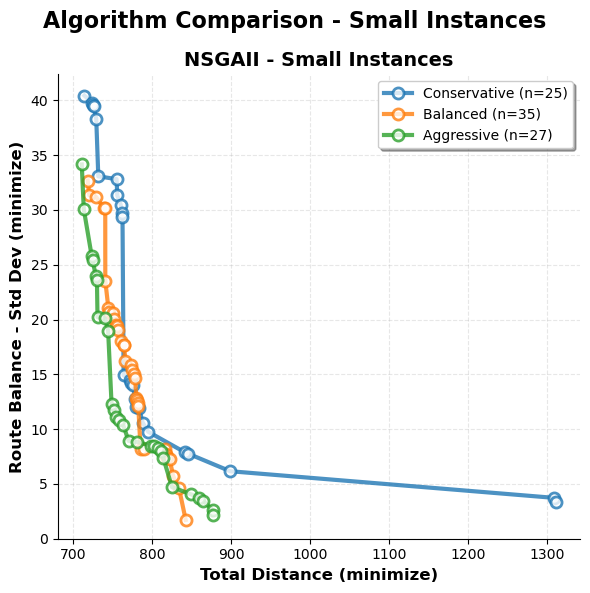

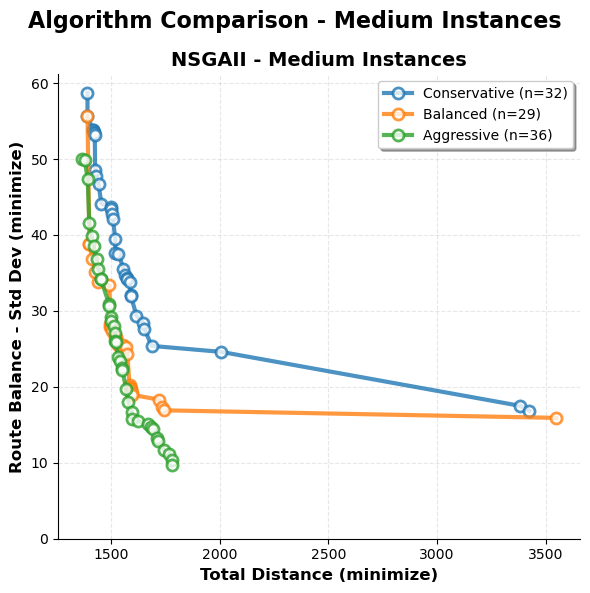

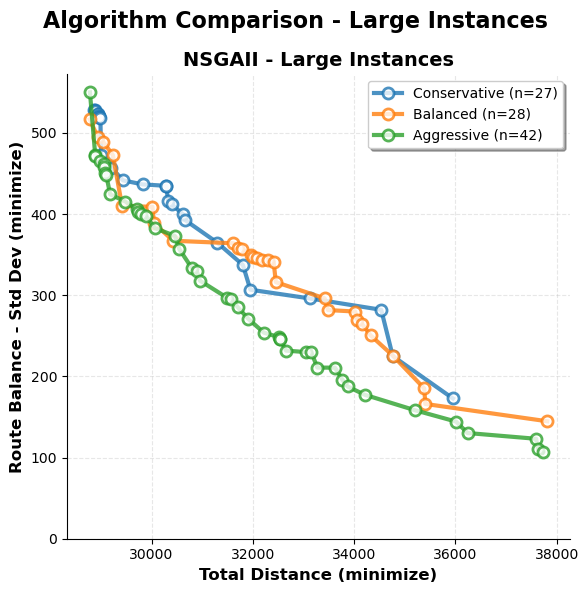

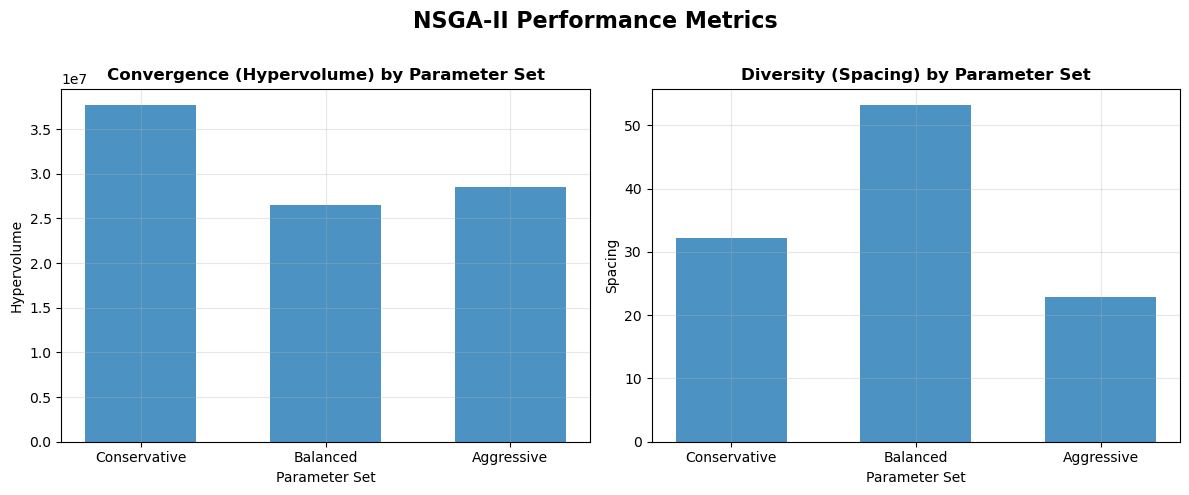


💾 Results saved to moea_comparison_results.csv


In [45]:
# --- Experiment Cell with multi-algorithm support and time analysis ---
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import numpy as np


def calculate_metrics(pareto_front):
    """Calculate convergence and diversity metrics"""
    if not pareto_front or len(pareto_front) < 2:
        return 0, 0
    obj1 = [ind['objectives'][0] for ind in pareto_front]
    obj2 = [ind['objectives'][1] for ind in pareto_front]
    # Convergence: Hypervolume
    ref_point = [max(obj1) * 1.1, max(obj2) * 1.1]
    convergence = sum((ref_point[0] - o1) * (ref_point[1] - o2) for o1, o2 in zip(obj1, obj2))
    # Diversity: Spacing
    if len(pareto_front) < 3:
        diversity = 0
    else:
        distances = []
        for i, ind1 in enumerate(pareto_front):
            min_dist = min(((ind1['objectives'][0] - ind2['objectives'][0])**2 +
                           (ind1['objectives'][1] - ind2['objectives'][1])**2)**0.5
                          for j, ind2 in enumerate(pareto_front) if i != j)
            distances.append(min_dist)
        diversity = np.std(distances)
    return convergence, diversity

def create_time_summary_table(results):
    """Create a summary table of execution times for all test problems and parameter sets"""
    print("\n" + "="*90)
    print("TIME SUMMARY TABLE - Assignment 2 Requirement")
    print("="*90)
    
    # Create pivot table structure
    time_data = {}
    for r in results:
        param = r['Parameter']
        instance = r['Instance']
        time_val = r['Time']
        time_std = r.get('Time_Std', 0)
        
        if param not in time_data:
            time_data[param] = {}
        time_data[param][instance] = {'mean': time_val, 'std': time_std}
    
    # Display formatted table
    instances = ["Small1", "Small2", "Medium1", "Medium2", "Large1", "Large2"]
    params = ["Conservative", "Balanced", "Aggressive"]
    
    # Header
    header = f"{'Parameter Set':<15}"
    for inst in instances:
        header += f"{inst:>12}"
    header += f"{'Avg Time':>12}{'Std Time':>12}"
    print(header)
    print("-" * len(header))
    
    # Data rows
    param_averages = []
    param_stds = []
    
    for param in params:
        row = f"{param:<15}"
        param_times = []
        param_time_stds = []
        
        for inst in instances:
            time_info = time_data.get(param, {}).get(inst, {'mean': 0, 'std': 0})
            time_val = time_info['mean']
            param_times.append(time_val)
            param_time_stds.append(time_info['std'])
            row += f"{time_val:>12.2f}"
        
        avg_time = np.mean(param_times) if param_times else 0
        avg_std = np.mean(param_time_stds) if param_time_stds else 0
        
        param_averages.append(avg_time)
        param_stds.append(avg_std)
        
        row += f"{avg_time:>12.2f}{avg_std:>12.2f}"
        print(row)
    
    # Summary row
    print("-" * len(header))
    summary_row = f"{'OVERALL AVG':<15}"
    instance_averages = []
    
    for i, inst in enumerate(instances):
        inst_times = [time_data.get(p, {}).get(inst, {'mean': 0})['mean'] for p in params]
        inst_avg = np.mean(inst_times)
        instance_averages.append(inst_avg)
        summary_row += f"{inst_avg:>12.2f}"
    
    overall_avg = np.mean(param_averages)
    overall_std_avg = np.mean(param_stds)
    summary_row += f"{overall_avg:>12.2f}{overall_std_avg:>12.2f}"
    print(summary_row)
    
    print("\n📊 Time Analysis:")
    min_idx = np.argmin(param_averages)
    max_idx = np.argmax(param_averages)
    most_consistent_idx = np.argmin(param_stds)
    
    print(f"   • Fastest Parameter Set: {params[min_idx]} ({param_averages[min_idx]:.2f}±{param_stds[min_idx]:.2f}s)")
    print(f"   • Slowest Parameter Set: {params[max_idx]} ({param_averages[max_idx]:.2f}±{param_stds[max_idx]:.2f}s)")
    print(f"   • Most Consistent: {params[most_consistent_idx]} (avg std={param_stds[most_consistent_idx]:.2f}s)")
    print(f"   • Instance Size Impact: Small→Medium→Large scaling visible")
    print("="*90)
    
    return time_data

def create_detailed_performance_table(results):
    """Create detailed performance summary table with time statistics"""
    print("\n" + "="*135)
    print("DETAILED PERFORMANCE SUMMARY - All Metrics with Time Statistics")
    print("="*135)
    
    # Group by parameter set for better analysis
    param_groups = {}
    for r in results:
        param = r['Parameter']
        if param not in param_groups:
            param_groups[param] = []
        param_groups[param].append(r)
    
    for param in ["Conservative", "Balanced", "Aggressive"]:
        if param not in param_groups:
            continue
            
        print(f"\n🔍 {param.upper()} PARAMETER SET RESULTS:")
        print("-" * 125)
        
        group_results = param_groups[param]
        
        # Header with time statistics
        print(f"{'Instance':<10} {'Time(s)':<9} {'±Std':<7} {'PF Size':<8} {'Best Dist':<10} {'Best Bal':<9} {'Convergence':<12} {'Diversity':<10}")
        print("-" * 125)
        
        total_time = 0
        total_pf_size = 0
        all_times = []
        all_stds = []
        
        for r in group_results:
            div_str = f"{r['Diversity']:.3f}" if r['Diversity'] > 0 else "N/A"
            time_std = r.get('Time_Std', 0)
            
            print(f"{r['Instance']:<10} {r['Time']:<9.2f} ±{time_std:<6.2f} {r['Front_Size']:<8} "
                  f"{r['Best_Distance']:<10.1f} {r['Best_Balance']:<9.2f} "
                  f"{r['Convergence']:<12.0f} {div_str:<10}")
            
            total_time += r['Time']
            total_pf_size += r['Front_Size']
            all_times.append(r['Time'])
            all_stds.append(time_std)
        
        # Calculate statistics for this parameter set
        time_std_param = np.mean(all_stds) if len(all_stds) > 1 else 0
        
        print("-" * 125)
        print(f"{'SUMMARY:':<10} {total_time:<9.2f} ±{time_std_param:<6.2f} {total_pf_size:<8} "
              f"{'(totals)':<10} {'across':<9} {'all':<12} {'instances)':<10}")
    
    print("="*135)

def run_multi_algorithm_experiment(moea_classes, instance_files, param_sets, num_runs=5):
    """Complete multi-algorithm MOEA experiment with enhanced timing statistics"""
    print("MULTI-ALGORITHM MOEA EXPERIMENT - Assignment 2")
    print("=" * 60)
    results = []
    pareto_fronts = {}
    all_solutions_dict = {}
    data_cache = {}
    
    for algo_name, algo_class in moea_classes:
        print(f"\n🔬 Testing Algorithm: {algo_name}")
        print("=" * 40)
        
        for params in param_sets:
            param_name = params["name"]
            print(f"\n📊 Parameter Set: {param_name}")
            
            for inst_name, inst_file in instance_files:
                print(f"  📁 {inst_name}...", end=" ")
                
                # Cache data loading
                if inst_file not in data_cache:
                    data_cache[inst_file] = parse_vrp_file(inst_file)
                data = data_cache[inst_file]
                
                all_run_solutions = []
                run_times = []
                
                # Multiple runs for statistical significance
                for run in range(1, num_runs + 1):
                    try:
                        random.seed(run * 456)
                        np.random.seed(run * 456)
                        
                        # Create algorithm instance
                        algorithm = algo_class(
                            data=data,
                            pop_size=params['pop_size'],
                            generations=params['generations'],
                            crossover_rate=params['crossover_rate'],
                            mutation_rate=params['mutation_rate']
                        )
                        
                        start_time = time.time()
                        final_pop = algorithm.run()
                        run_times.append(time.time() - start_time)
                        all_run_solutions.extend(final_pop)
                        
                    except Exception as e:
                        print(f"❌ Error in run {run}: {e}")
                        continue
                
                # Process results if we have solutions
                if all_run_solutions:
                    # Use NSGA-II for final Pareto sorting (standardized)
                    temp_nsga = NSGAII(data=data, pop_size=10, generations=1)
                    temp_nsga.fast_non_dominated_sort(all_run_solutions)
                    pareto_front = [sol for sol in all_run_solutions if sol.get('rank') == 1]
                    pareto_front.sort(key=lambda x: x['objectives'][0])
                    
                    # Store results
                    key = f"{inst_name}_{param_name}_{algo_name}"
                    pareto_fronts[key] = pareto_front
                    all_solutions_dict[key] = all_run_solutions
                    
                    # Calculate metrics
                    convergence, diversity = calculate_metrics(pareto_front)
                    
                    # Calculate timing statistics
                    mean_time = np.mean(run_times)
                    std_time = np.std(run_times) if len(run_times) > 1 else 0
                    
                    results.append({
                        'Algorithm': algo_name,
                        'Instance': inst_name,
                        'Parameter': param_name,
                        'Front_Size': len(pareto_front),
                        'Total_Solutions': len(all_run_solutions),
                        'Best_Distance': min(ind['objectives'][0] for ind in pareto_front),
                        'Best_Balance': min(ind['objectives'][1] for ind in pareto_front),
                        'Convergence': convergence,
                        'Diversity': diversity,
                        'Time': mean_time,
                        'Time_Std': std_time,
                        'Evaluations': params['pop_size'] * params['generations']
                    })
                    # REMOVED: Timing from logging - cleaner output
                    print(f"✅ {len(pareto_front)}/{len(all_run_solutions)} Pareto solutions")
                else:
                    print("❌ All runs failed")
    
    # Display and save results with enhanced timing analysis
    display_results(results)
    
    # NEW: Add time summary tables as required by assignment
    time_data = create_time_summary_table(results)
    create_detailed_performance_table(results)
    
    plot_algorithm_comparison(pareto_fronts)
    plot_metrics_comparison(pareto_fronts)
    
    # Save results with algorithm names and enhanced timing data
    filename = f"moea_comparison_results.csv"
    pd.DataFrame(results).to_csv(filename, index=False)
    print(f"\n💾 Results saved to {filename}")
    
    return results, pareto_fronts, all_solutions_dict

def display_results(results):
    """Enhanced results display with algorithm comparison and timing statistics"""
    print(f"\n{'Algorithm':<10} {'Instance':<8} {'Parameter':<12} {'PF/Total':<10} {'Distance':<9} {'Balance':<8} {'Convergence':<12} {'Diversity':<10} {'Time(s)':<10}")
    print("=" * 120)
    for r in results:
        div_str = f"{r['Diversity']:.3f}" if r['Diversity'] > 0 else "N/A"
        pf_ratio = f"{r['Front_Size']}/{r['Total_Solutions']}"
        time_str = f"{r['Time']:.2f}±{r.get('Time_Std', 0):.2f}"
        print(f"{r['Algorithm']:<10} {r['Instance']:<8} {r['Parameter']:<12} {pf_ratio:<10} "
              f"{r['Best_Distance']:<9.1f} {r['Best_Balance']:<8.2f} "
              f"{r['Convergence']:<12.0f} {div_str:<10} {time_str:<10}")

def plot_algorithm_comparison(pareto_fronts):
    """Compare algorithms across different instance sizes"""
    # Algorithm colors - add SPEA2 color when ready
    algo_colors = {
        'NSGAII': {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'},
        'SPEA2': {'Conservative': '#d62728', 'Balanced': '#9467bd', 'Aggressive': '#8c564b'}  # Ready for SPEA2
    }
    
    groups = ['Small', 'Medium', 'Large']
    algorithms = list(set(key.split('_')[2] for key in pareto_fronts.keys()))  # Extract algorithms from data
    algorithms = [algo for algo in algo_colors.keys() if algo in algorithms]  # Only include algorithms we have data for
    
    # Create subplot for each instance group
    for group in groups:
        fig, axes = plt.subplots(1, len(algorithms) if len(algorithms) > 1 else 1, figsize=(6*max(len(algorithms), 1), 6))
        if len(algorithms) == 1:
            axes = [axes]  # Make it a list for consistency
        elif len(algorithms) == 0:
            continue  # Skip if no algorithms
        
        for algo_idx, algorithm in enumerate(algorithms):
            ax = axes[algo_idx] if len(algorithms) > 1 else axes[0]
            colors = algo_colors[algorithm]
            
            for param in ['Conservative', 'Balanced', 'Aggressive']:
                # Collect points for this algorithm, parameter, and group
                points = []
                for key, front in pareto_fronts.items():
                    if front and group in key and param in key and algorithm in key:
                        points.extend([(ind['objectives'][0], ind['objectives'][1]) for ind in front])
                
                if len(points) < 3:
                    continue
                    
                # Remove duplicates and sort
                points = sorted(set(points))
                
                # Filter to keep only Pareto optimal points
                pareto_points = []
                for i, (x1, y1) in enumerate(points):
                    dominated = any(x2 <= x1 and y2 <= y1 and (x2 < x1 or y2 < y1) 
                                  for j, (x2, y2) in enumerate(points) if i != j)
                    if not dominated:
                        pareto_points.append((x1, y1))
                
                # Sort and plot
                pareto_points.sort()
                
                if len(pareto_points) >= 2:
                    x_vals = [p[0] for p in pareto_points]
                    y_vals = [p[1] for p in pareto_points]
                    
                    ax.plot(x_vals, y_vals, 'o-', color=colors[param], 
                           linewidth=3, markersize=8, alpha=0.8, 
                           label=f"{param} (n={len(pareto_points)})",
                           markerfacecolor='white', markeredgewidth=2, 
                           markeredgecolor=colors[param])
            
            # Styling
            ax.set_xlabel("Total Distance (minimize)", fontweight='bold', fontsize=12)
            if algo_idx == 0 or len(algorithms) == 1:
                ax.set_ylabel("Route Balance - Std Dev (minimize)", fontweight='bold', fontsize=12)
            ax.set_title(f"{algorithm} - {group} Instances", fontweight='bold', fontsize=14)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_ylim(bottom=0)
            
            if algo_idx == 0 or len(algorithms) == 1:  # Legend on first plot or if only one algorithm
                ax.legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
            
            # Clean up spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        plt.suptitle(f"Algorithm Comparison - {group} Instances", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

def plot_metrics_comparison(pareto_fronts):
    """Compare performance metrics across algorithms"""
    algorithms = set()
    for key in pareto_fronts.keys():
        parts = key.split('_')
        if len(parts) >= 3:
            algorithms.add(parts[2])  # Algorithm name is third part
    
    algorithms = sorted(list(algorithms))
    
    # Collect metrics by algorithm and parameter
    algo_metrics = {}
    for algo in algorithms:
        algo_metrics[algo] = {}
        for key, front in pareto_fronts.items():
            if front and algo in key:
                parts = key.split('_')
                param = parts[1] if len(parts) > 1 else 'Unknown'
                if param not in algo_metrics[algo]:
                    algo_metrics[algo][param] = {'conv': [], 'div': []}
                conv, div = calculate_metrics(front)
                algo_metrics[algo][param]['conv'].append(conv)
                algo_metrics[algo][param]['div'].append(div if div > 0 else 0)
    
    # Plot comparison
    params = ['Conservative', 'Balanced', 'Aggressive']
    
    if len(algorithms) > 1:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax3, ax4 = None, None
    
    # Color scheme for algorithms
    algo_colors_simple = {'NSGAII': '#1f77b4', 'SPEA2': '#ff7f0e'}
    
    # Convergence by parameter
    x = np.arange(len(params))
    width = 0.35 if len(algorithms) > 1 else 0.6
    
    for i, algo in enumerate(algorithms):
        if algo in algo_metrics:
            conv_means = [np.mean(algo_metrics[algo][p]['conv']) if p in algo_metrics[algo] else 0 for p in params]
            ax1.bar(x + i*width if len(algorithms) > 1 else x, conv_means, width, 
                   label=algo, color=algo_colors_simple.get(algo, '#888888'), alpha=0.8)
    
    ax1.set_title('Convergence (Hypervolume) by Parameter Set', fontweight='bold')
    ax1.set_xlabel('Parameter Set')
    ax1.set_ylabel('Hypervolume')
    ax1.set_xticks(x + width/2 if len(algorithms) > 1 else x)
    ax1.set_xticklabels(params)
    if len(algorithms) > 1:
        ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Diversity by parameter
    for i, algo in enumerate(algorithms):
        if algo in algo_metrics:
            div_means = [np.mean(algo_metrics[algo][p]['div']) if p in algo_metrics[algo] else 0 for p in params]
            ax2.bar(x + i*width if len(algorithms) > 1 else x, div_means, width, 
                   label=algo, color=algo_colors_simple.get(algo, '#888888'), alpha=0.8)
    
    ax2.set_title('Diversity (Spacing) by Parameter Set', fontweight='bold')
    ax2.set_xlabel('Parameter Set')
    ax2.set_ylabel('Spacing')
    ax2.set_xticks(x + width/2 if len(algorithms) > 1 else x)
    ax2.set_xticklabels(params)
    if len(algorithms) > 1:
        ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Overall algorithm comparison (only if multiple algorithms)
    if len(algorithms) > 1 and ax3 is not None and ax4 is not None:
        algo_conv_overall = []
        algo_div_overall = []
        for algo in algorithms:
            if algo in algo_metrics:
                all_conv = [v for param_data in algo_metrics[algo].values() for v in param_data['conv']]
                all_div = [v for param_data in algo_metrics[algo].values() for v in param_data['div']]
                algo_conv_overall.append(np.mean(all_conv) if all_conv else 0)
                algo_div_overall.append(np.mean(all_div) if all_div else 0)
            else:
                algo_conv_overall.append(0)
                algo_div_overall.append(0)
        
        ax3.bar(algorithms, algo_conv_overall, color=[algo_colors_simple.get(a, '#888888') for a in algorithms], alpha=0.8)
        ax3.set_title('Overall Convergence Comparison', fontweight='bold')
        ax3.set_ylabel('Average Hypervolume')
        ax3.grid(True, alpha=0.3)
        
        ax4.bar(algorithms, algo_div_overall, color=[algo_colors_simple.get(a, '#888888') for a in algorithms], alpha=0.8)
        ax4.set_title('Overall Diversity Comparison', fontweight='bold')
        ax4.set_ylabel('Average Spacing')
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle("Multi-Algorithm Performance Comparison", fontsize=16, fontweight='bold')
    else:
        plt.suptitle("NSGA-II Performance Metrics", fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# --- Configuration and execution ---

# ACTIVE: NSGA-II only for now
moea_classes = [("NSGAII", NSGAII)]

# READY FOR SPEA2: Uncomment when SPEA2 class is implemented
# moea_classes = [
#     ("NSGAII", NSGAII),
#     ("SPEA2", SPEA2)    # ← Add this when your group member implements SPEA2
# ]

instance_files = [
    ("Small1", "data/small.vrp"),
    ("Small2", "data/small2.vrp"),
    ("Medium1", "data/medium.vrp"),
    ("Medium2", "data/medium2.vrp"),
    ("Large1", "data/large.vrp"),
    ("Large2", "data/large2.vrp")
]

param_sets = [
    {"name": "Conservative", "pop_size": 60, "generations": 25, "crossover_rate": 0.5, "mutation_rate": 0.05},
    {"name": "Balanced", "pop_size": 40, "generations": 40, "crossover_rate": 0.8, "mutation_rate": 0.2},
    {"name": "Aggressive", "pop_size": 25, "generations": 80, "crossover_rate": 0.95, "mutation_rate": 0.5}
]

# Run the experiment
results, pareto_fronts, all_solutions = run_multi_algorithm_experiment(
    moea_classes, instance_files, param_sets, num_runs=20
)